# Load packages

In [1]:
%matplotlib inline 
import numpy as np 
import pylab as pl 
from wmf import wmf
import glob
import pandas as pd 
from string import Template

# Set the run

In [2]:
# reads the watershed 
cu = wmf.SimuBasin(rute='TurkeyBasin_simSetup.nc')
wmf.models.dt = 3600.
wmf.models.show_storage = 1

# reads rainfall 
year = '2016'
rain = wmf.read_rain_struct('stage4Rainfall/rain_'+year+'.hdr')
rain_bin = 'stage4Rainfall/rain_'+year+'.bin'

# reads the evaporation
et = pd.read_msgpack('MODIS_processed_et.msg')
et = et/10.

In [5]:
#set limits on the capilar and gravitational storages
wmf.models.retorno_aq = 1
wmf.models.retorno_gr = 1

In [7]:
#Observed streamflow records
obs = {'05412500':{'link': 434514, 'mod_l': 20},
      '05412400':{'link': 399711, 'mod_l': 414},
      '05412020':{'link': 434478, 'mod_l': 712},
      '05411900':{'link': 418967, 'mod_l': 2778},
      '05411850':{'link': 434365, 'mod_l': 4447},
      '05411600':{'link': 483619, 'mod_l': 6273}}
Qobs = {}
for k in obs.keys():
    try:
        qo = pd.read_msgpack('/Users/nicolas/BaseData/USGS_hourly/'+str(obs[k]['link'])+'.msg')
        Qobs.update({str(obs[k]['mod_l']): qo})
    except:
        pass

In [9]:
# Script to find the dates of the simulation period
#year = '2014'
f1 = year + '-04-01'
try:
    f1loc = rain.index.get_loc(f1).start
except:
    f1loc = rain.index.get_loc(f1)[0]

f2 = year + '-07-20'
try:
    f2loc = rain.index.get_loc(f2).stop
except:
    f2loc = rain.index.get_loc(f2)[-1]
Nsteps = f2loc - f1loc

In [10]:
#Set the dates at which the model takes snapshots of the simulated states
save_dates=  pd.read_csv('rainyDay/EventsList.csv', index_col=0, parse_dates=True)
save_dates.sort_index(inplace=True)
save_dates = save_dates.index.intersection(rain.index[f1loc:f1loc+Nsteps])
save_dates = save_dates.unique()

In [8]:
# Initial conditions 
cu.set_Storage(90, 0)
cu.set_Storage(0.000001, 1)
cu.set_Storage(2.0, 2)
cu.set_Storage(35, 3)
cu.set_Storage(0.00001, 4)

Run the model 

In [12]:
%%time
#wmf.models.h_exp[3] = 0.15
Param = [0.000325, 2.0, 2.0, 0.0, 0.2, 0.00012, 0.01, 0.005, 1.0, 1.0, 1.0]
Param = [0.000325, 2.0, 2.0, 0.0, 0.2, 0.00012, 0.01, 0.008, 1.0, 1.0, 1.0]

# Run the model
R = cu.run_shia(Param, rain_bin, Nsteps, f1loc,ruta_storage='ensayo.bin',
    EvpVariable = 'serie', 
    EvpSerie = et.values[f1loc:f2loc],) 
    #WheretoStore = save_dates)#pd.to_datetime(['2002-04-02 00:00','2002-04-03 00:00','2002-04-03 05:00']))

CPU times: user 6min 30s, sys: 14.5 s, total: 6min 44s
Wall time: 15min 37s


# Comparing results at several stations

In [284]:
# Sim period
year = '2018'
f1 = year + '-04-01'
f2 = year + '-12-30'
qs = pd.read_msgpack('outputs/streamflow/r02_'+year+'.msg')

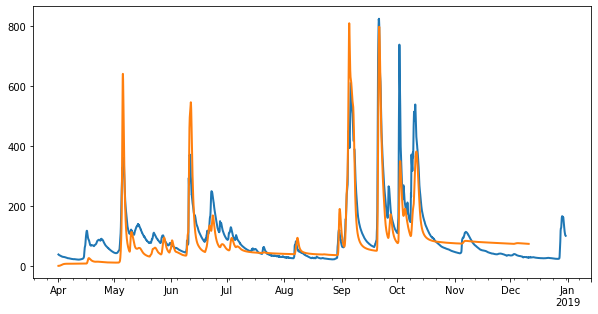

In [285]:
fig = pl.figure(figsize=(10,5))
Qobs['20'][f1:f2].plot.line(fig = fig, lw = 2, label = 'obs')
#R[1]['20'].plot.line(fig = fig, lw = 2, label = 'sim')
qs['20'][f1:f2].plot.line(fig = fig, lw = 2, label = 'sim')


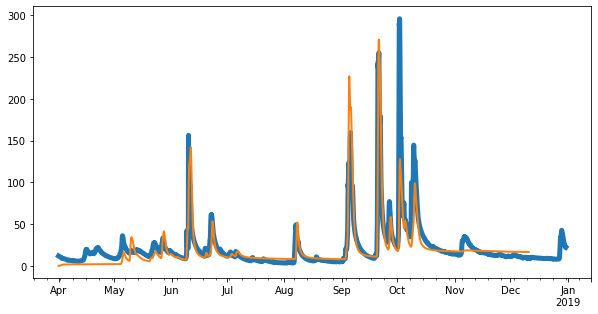

In [286]:
fig = pl.figure(figsize=(10,5))
Qobs['414'][f1:f2].plot.line(fig = fig, lw = 5, label = 'obs')
#R[1]['414'].plot.line(fig = fig, lw = 2, label = 'sim')
qs['414'][f1:f2].plot.line(fig = fig, lw = 2, label = 'sim')

#q2['414'].plot.line(fig = fig, lw = 2, label = 'sim2')

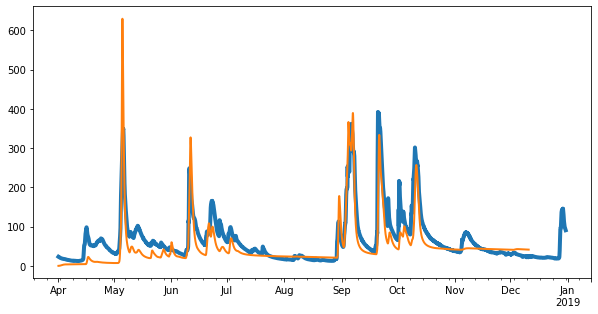

In [287]:
fig = pl.figure(figsize=(10,5))
Qobs['712'][f1:f2].plot.line(fig = fig, lw = 4, label = 'obs')
#R[1]['712'].plot.line(fig = fig, lw = 2, label = 'sim')
qs['712'][f1:f2].plot.line(fig = fig, lw = 2, label = 'sim')

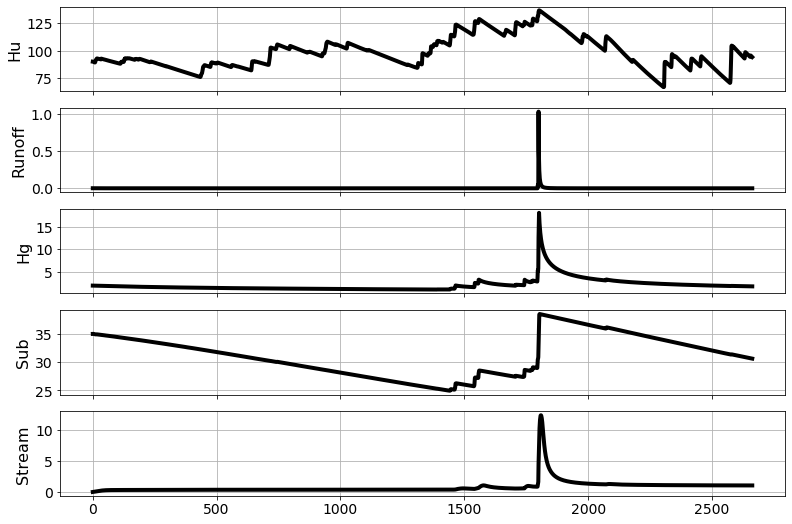

In [19]:
#Plot of the simulated states
wmf.plot_mean_storage(R[0]['Mean_Storage'])